<ipython-input-7-682fe0ee6b58>:14: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  train_df = pd.read_csv("/content/preprocessed_train_data (1).csv")
<ipython-input-7-682fe0ee6b58>:27: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_df[target_col].fillna(train_df[target_col].mode()[0], inplace=True)



Classification Report:
              precision    recall  f1-score   support

           1       1.00      0.99      0.99     37797
           2       0.99      0.99      0.99     31012
           3       0.68      0.81      0.74      5481
           4       0.99      1.00      0.99     34487
           5       0.81      0.70      0.75      6670
           6       1.00      0.99      1.00     33842

    accuracy                           0.97    149289
   macro avg       0.91      0.91      0.91    149289
weighted avg       0.98      0.97      0.97    149289



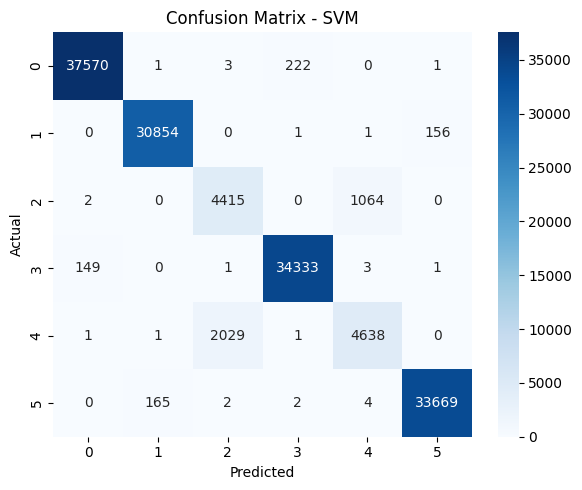

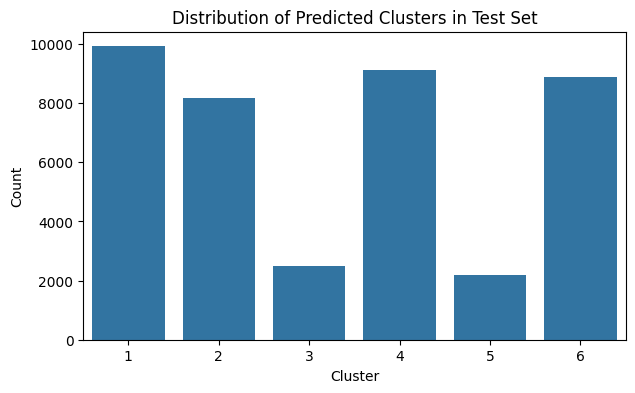


Predicted Clusters for Test Set:
   Customer_ID  Predicted_cluster
0        33574                  1
1        10089                  1
2        38329                  1
3        11376                  1
4        12410                  1
5          826                  1
6        10364                  4
7        39986                  1
8        11133                  1
9        32747                  1


In [7]:
# Step 1: Import Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.svm import LinearSVC, SVC
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
import collections

# Step 2: Load Data
train_df = pd.read_csv("/content/preprocessed_train_data (1).csv")
test_df = pd.read_csv("/content/preprocessed_test_data (1).csv")

# Step 3: Encode 'outlet_city'
combined_cities = pd.concat([train_df["outlet_city"], test_df["outlet_city"]], axis=0).astype(str)
city_encoder = LabelEncoder()
city_encoder.fit(combined_cities)

train_df["outlet_city"] = city_encoder.transform(train_df["outlet_city"].astype(str))
test_df["outlet_city"] = city_encoder.transform(test_df["outlet_city"].astype(str))

# Step 4: Clean Target Variable
target_col = "cluster_catgeory"
train_df[target_col].fillna(train_df[target_col].mode()[0], inplace=True)
train_df[target_col] = train_df[target_col].astype(str).str.extract(r"(\d+)")[0]
train_df = train_df[train_df[target_col].notna()]
train_df[target_col] = train_df[target_col].astype(int)

# Step 5: Remove Rare Classes
rare_classes = [89, 95, 98, 99, 100]
train_df = train_df[~train_df[target_col].isin(rare_classes)]

# Step 6: Split Features and Target
X = train_df.drop(columns=["Customer_ID", target_col])
y = train_df[target_col]

# Step 7: Stratified Train-Test Split
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_idx, val_idx in split.split(X, y):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

# Step 8: Feature Scaling
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

# Step 9: Balance Classes using SMOTE (Increase sampling for smaller classes)
sm = SMOTE(sampling_strategy='auto', random_state=42)
X_train, y_train = sm.fit_resample(X_train, y_train)

# Step 10: Train the Linear SVM Model (or RBF Kernel if you switch)
svm_model = LinearSVC(max_iter=10000, dual=False, class_weight='balanced', random_state=42)
svm_model.fit(X_train, y_train)

# Step 11: Evaluate on Validation Set
y_pred = svm_model.predict(X_val)
print("\nClassification Report:")
print(classification_report(y_val, y_pred))

# Step 12: Confusion Matrix
cm = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - SVM")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# Step 13: Predict on Test Data
X_test = test_df.drop(columns=["Customer_ID"])
X_test_scaled = scaler.transform(X_test)
test_predictions = svm_model.predict(X_test_scaled)
test_df["Predicted_cluster"] = test_predictions

# Step 14: Show Prediction Distribution
pred_counts = collections.Counter(test_predictions)
plt.figure(figsize=(7, 4))
sns.barplot(x=list(pred_counts.keys()), y=list(pred_counts.values()))
plt.title("Distribution of Predicted Clusters in Test Set")
plt.xlabel("Cluster")
plt.ylabel("Count")
plt.show()

# Step 15: Display Sample Output
print("\nPredicted Clusters for Test Set:")
print(test_df[["Customer_ID", "Predicted_cluster"]].head(10))

# Step 16: Export Prediction
test_df.to_csv("svm_test_predictions.csv", index=False)
